In [1]:
# data manipulation
import pandas as pd
import numpy as np

# pre processing
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN

# model
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier

# metrics
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score

# plotting
import matplotlib.pyplot as plt

# saving
import joblib

In [2]:
X_train = joblib.load('data/X_train_preprocessed.pkl')
X_test = joblib.load('data/X_test_preprocessed.pkl')
y_train = joblib.load('data/y_train_preprocessed.pkl')
y_test = joblib.load('data/y_test_preprocessed.pkl')

In [3]:
scoring = {
    'accuracy': 'accuracy',
    'precision_macro': make_scorer(precision_score, average='macro'),
    'recall_macro': make_scorer(recall_score, average='macro'),
    'f1_macro': make_scorer(f1_score, average='macro')
}

In [4]:
knn = KNeighborsClassifier()
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

In [5]:
param_grid = [
    {
        'metric': ['minkowski'],
        'p': [1, 2],  # hyperparametro usado apenas com a metrica minkowski
        'n_neighbors': [1, 3, 5, 7, 9, 11, 15, 20],
        'weights': ['uniform', 'distance']
    },
    {
        'metric': ['euclidean', 'manhattan'],
        'n_neighbors': [1, 3, 5, 7, 9, 11, 15, 20],
        'weights': ['uniform', 'distance']
    }
]

In [11]:
def train_grid_search(X, y, estimator, grid):
    grid_search = GridSearchCV(
        estimator=estimator,
        param_grid=grid,
        cv=skf,
        scoring=scoring,
        refit='f1_macro',
        n_jobs=-1,
        return_train_score=True
    )

    grid_search.fit(X, y)

    return grid_search

In [23]:
def get_results(g_search):
    results = pd.DataFrame(g_search.cv_results_)
    
    results = results[
        [
            'mean_fit_time', 'mean_score_time', 'param_metric', 'param_n_neighbors', 'param_p',
            'param_weights', 'mean_train_accuracy', 'mean_test_accuracy', 'rank_test_accuracy' 'mean_train_precision_macro', 
            'mean_test_precision_macro', 'rank_test_precision_macro', 'mean_train_recall_macro', 'mean_test_recall_macro', 
            'rank_test_recall_macro', 'mean_train_f1_macro', 'mean_test_f1_macro', 'rank_test_f1_macro'
        ]
    ]

    results = results.sort_values(by='mean_test_f1_macro', ascending=False)
    return results

In [9]:
pd.set_option('display.max_columns', None)

In [16]:
grid_search = train_grid_search(X_train, y_train, knn, param_grid)
results = get_results(grid_search)

In [20]:
results.head(10)

,mean_fit_time,mean_score_time,param_metric,param_n_neighbors,param_p,param_weights,mean_train_accuracy,mean_test_accuracy,mean_train_precision_macro,mean_test_precision_macro,mean_train_recall_macro,mean_test_recall_macro,mean_train_f1_macro,mean_test_f1_macro,rank_test_accuracy,rank_test_precision_macro,rank_test_recall_macro,rank_test_f1_macro
32,0.007707,0.093648,euclidean,1,NaN,uniform,1.000000,0.847885,1.000000,0.724178,1.000000,0.725262,1.00000,0.724494,55,55,1,1
2,0.009632,0.079879,minkowski,1,2.0,uniform,1.000000,0.847885,1.000000,0.724178,1.000000,0.725262,1.00000,0.724494,55,55,1,1
3,0.009366,0.076357,minkowski,1,2.0,distance,1.000000,0.847885,1.000000,0.724178,1.000000,0.725262,1.00000,0.724494,55,55,1,1
33,0.007999,0.059955,euclidean,1,NaN,distance,1.000000,0.847885,1.000000,0.724178,1.000000,0.725262,1.00000,0.724494,55,55,1,1
47,0.008307,0.063110,euclidean,20,NaN,distance,1.000000,0.888470,1.000000,0.920500,1.000000,0.668159,1.00000,0.717805,1,1,13,5
31,0.007203,0.066756,minkowski,20,2.0,distance,1.000000,0.888470,1.000000,0.920500,1.000000,0.668159,1.00000,0.717805,1,1,13,5
7,0.007653,0.060447,minkowski,3,2.0,distance,1.000000,0.861700,1.000000,0.757086,1.000000,0.687416,1.00000,0.711878,27,35,9,7
35,0.007914,0.058280,euclidean,3,NaN,distance,1.000000,0.861700,1.000000,0.757086,1.000000,0.687416,1.00000,0.711878,27,35,9,7
6,0.008758,0.058300,minkowski,3,2.0,uniform,0.933853,0.861529,0.909711,0.756680,0.838426,0.686901,0.86866,0.711340,29,37,11,9
34,0.008166,0.106159,euclidean,3,NaN,uniform,0.933853,0.861529,0.909711,0.756680,0.838426,0.686901,0.86866,0.711340,29,37,11,9


In [24]:
default_metrics = [
    "mean_train_accuracy", "mean_test_accuracy",
    "mean_train_precision_macro", "mean_test_precision_macro",
    "mean_train_recall_macro", "mean_test_recall_macro",
    "mean_train_f1_macro", "mean_test_f1_macro"
]

In [49]:
def view_test_metrics(train_metrics: bool, filter_top_n: int, results_df: pd.DataFrame):
    if train_metrics:
        metrics = [
            "mean_train_accuracy", "mean_test_accuracy",
            "mean_train_precision_macro", "mean_test_precision_macro",
            "mean_train_recall_macro", "mean_test_recall_macro",
            "mean_train_f1_macro", "mean_test_f1_macro"
        ]
    else:
        metrics = [
            "mean_test_accuracy",
            "mean_test_precision_macro",
            "mean_test_recall_macro",
            "mean_test_f1_macro"
        ]

    if filter_top_n:
        results_df = results_df.nsmallest(filter_top_n, "rank_test_f1_macro")

    param_cols = ["param_n_neighbors", "param_metric", "param_weights", "param_p"]
    plot_df = results_df.melt(
        id_vars=param_cols,      # keep these columns "as is"
        value_vars=metrics,      # the columns we want to "unpivot"
        var_name="metric",       # new column with the metric name
        value_name="score"       # new column with the metric value
    )

    plt.figure(figsize=(12, 8))


    for combo, group in plot_df.groupby(param_cols):
        # Sort the group by metric name (if desired)
        group = group.sort_values("metric")
        # Create a label for this parameter combination
        label_str = ", ".join(f"{col}={val}" for col, val in zip(param_cols, combo))
        
        # Separate train and test metrics using .str.startswith on the 'metric' column
        train_group = group[group["metric"].str.startswith("mean_train")]
        test_group = group[~group["metric"].str.startswith("mean_train")]

        # Plot training metrics with a dashed line and an 'x' marker (with transparency)
        if not train_group.empty:
            plt.plot(train_group["metric"], train_group["score"], 
                     marker='x', linestyle='dashed', alpha=0.7,
                     label=label_str + " (train)")
        # Plot test metrics with a solid line and an 'o' marker (with transparency)
        if not test_group.empty:
            plt.plot(test_group["metric"], test_group["score"], 
                     marker='o', linestyle='solid', alpha=0.7,
                     label=label_str + " (test)")

    plt.xlabel("Metric")
    plt.ylabel("Score")
    plt.title("Comparison of Mean Test Metrics")
    plt.xticks(rotation=45)
    # Adjust the legend to avoid cluttering the plot
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
    plt.tight_layout()
    plt.show()  

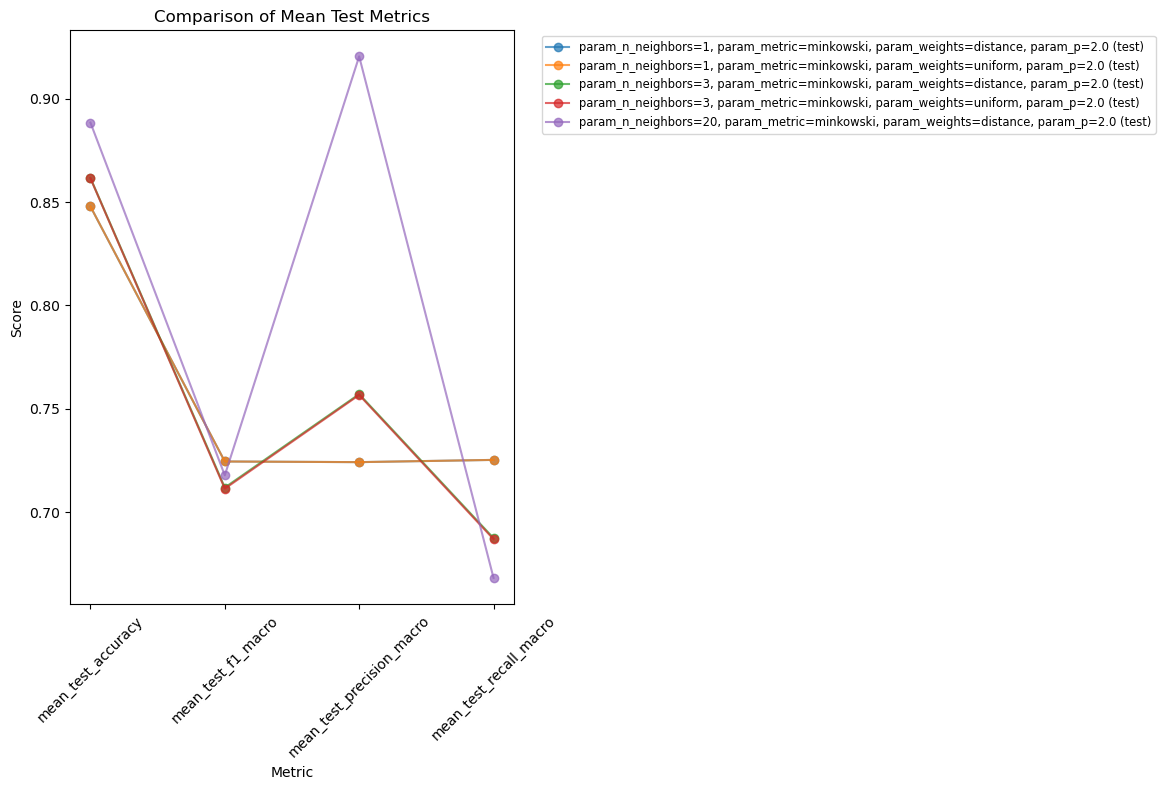

In [53]:
view_test_metrics(False, 10, results)

In [56]:
joblib.dump(grid_search.best_estimator_, 'models/knn.pkl')

['models/knn.pkl']

Como os modelos ficaram com recall e, consequentemente, f1-score baixo, isso indica que o modelo provavelmente está com bom desempenho para a classe dominante (ja que a acurácia está boa), mas não para a outra. Isso pode acontecer por conta do desbalanceamento entre as classes, então podemos tentar aplicar técnicas de balanceamento.

In [54]:
def os_smote(X, y):
    # auto faz resampling de todas as classes, menos a minoritária
    smote = SMOTE(sampling_strategy='auto', random_state=42, k_neighbors=5)
    X_balanced, y_balanced = smote.fit_resample(X, y)
    
    return X_balanced, y_balanced

In [57]:
pipeline = Pipeline([
    ('oversampler', RandomOverSampler(sampling_strategy='auto', random_state=42)),
    ('knn', KNeighborsClassifier())
])

In [58]:
param_grid = [
    {
        'knn__metric': ['minkowski'],
        'knn__p': [1, 2],  # hyperparametro usado apenas com a metrica minkowski
        'knn__n_neighbors': [1, 3, 5, 7, 9, 11, 15, 20],
        'knn__weights': ['uniform', 'distance']
    },
    {
        'knn__metric': ['euclidean', 'manhattan'],
        'knn__n_neighbors': [1, 3, 5, 7, 9, 11, 15, 20],
        'knn__weights': ['uniform', 'distance']
    }
]

In [62]:
def get_results_pipeline(g_search):
    results = pd.DataFrame(g_search.cv_results_)
    
    results = results[
        [
            'mean_fit_time', 'mean_score_time', 'param_knn__metric', 'param_knn__n_neighbors', 'param_knn__p',
            'param_knn__weights', 'mean_train_accuracy', 'mean_test_accuracy', 'rank_test_accuracy', 'mean_train_precision_macro', 
            'mean_test_precision_macro', 'rank_test_precision_macro', 'mean_train_recall_macro', 'mean_test_recall_macro', 
            'rank_test_recall_macro', 'mean_train_f1_macro', 'mean_test_f1_macro', 'rank_test_f1_macro'
        ]
    ]

    results = results.sort_values(by='mean_test_f1_macro', ascending=False)
    return results

In [64]:
def view_test_metrics_pipeline(train_metrics: bool, filter_top_n: int, results_df: pd.DataFrame):
    if train_metrics:
        metrics = [
            "mean_train_accuracy", "mean_test_accuracy",
            "mean_train_precision_macro", "mean_test_precision_macro",
            "mean_train_recall_macro", "mean_test_recall_macro",
            "mean_train_f1_macro", "mean_test_f1_macro"
        ]
    else:
        metrics = [
            "mean_test_accuracy",
            "mean_test_precision_macro",
            "mean_test_recall_macro",
            "mean_test_f1_macro"
        ]

    if filter_top_n:
        results_df = results_df.nsmallest(filter_top_n, "rank_test_f1_macro")

    param_cols = ["param_knn__n_neighbors", "param_knn__metric", "param_knn__weights", "param_knn__p"]
    plot_df = results_df.melt(
        id_vars=param_cols,      # keep these columns "as is"
        value_vars=metrics,      # the columns we want to "unpivot"
        var_name="metric",       # new column with the metric name
        value_name="score"       # new column with the metric value
    )

    plt.figure(figsize=(12, 8))


    for combo, group in plot_df.groupby(param_cols):
        # Sort the group by metric name (if desired)
        group = group.sort_values("metric")
        # Create a label for this parameter combination
        label_str = ", ".join(f"{col}={val}" for col, val in zip(param_cols, combo))
        
        # Separate train and test metrics using .str.startswith on the 'metric' column
        train_group = group[group["metric"].str.startswith("mean_train")]
        test_group = group[~group["metric"].str.startswith("mean_train")]

        # Plot training metrics with a dashed line and an 'x' marker (with transparency)
        if not train_group.empty:
            plt.plot(train_group["metric"], train_group["score"], 
                     marker='x', linestyle='dashed', alpha=0.7,
                     label=label_str + " (train)")
        # Plot test metrics with a solid line and an 'o' marker (with transparency)
        if not test_group.empty:
            plt.plot(test_group["metric"], test_group["score"], 
                     marker='o', linestyle='solid', alpha=0.7,
                     label=label_str + " (test)")

    plt.xlabel("Metric")
    plt.ylabel("Score")
    plt.title("Comparison of Mean Test Metrics")
    plt.xticks(rotation=45)
    # Adjust the legend to avoid cluttering the plot
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
    plt.tight_layout()
    plt.show()  

In [66]:
grid_search = train_grid_search(X_train, y_train, pipeline, param_grid)
results = get_results_pipeline(grid_search)

In [68]:
results.head(10)

,mean_fit_time,mean_score_time,param_knn__metric,param_knn__n_neighbors,param_knn__p,param_knn__weights,mean_train_accuracy,mean_test_accuracy,rank_test_accuracy,mean_train_precision_macro,mean_test_precision_macro,rank_test_precision_macro,mean_train_recall_macro,mean_test_recall_macro,rank_test_recall_macro,mean_train_f1_macro,mean_test_f1_macro,rank_test_f1_macro
32,0.017500,0.126569,euclidean,1,NaN,uniform,1.000000,0.847885,1,1.000000,0.724178,1,1.000000,0.725262,35,1.000000,0.724494,1
2,0.023312,0.102346,minkowski,1,2.0,uniform,1.000000,0.847885,1,1.000000,0.724178,1,1.000000,0.725262,35,1.000000,0.724494,1
3,0.020627,0.099880,minkowski,1,2.0,distance,1.000000,0.847885,1,1.000000,0.724178,1,1.000000,0.725262,35,1.000000,0.724494,1
33,0.017852,0.091372,euclidean,1,NaN,distance,1.000000,0.847885,1,1.000000,0.724178,1,1.000000,0.725262,35,1.000000,0.724494,1
1,0.017175,0.611830,minkowski,1,1.0,distance,1.000000,0.838844,5,1.000000,0.706461,5,1.000000,0.702768,55,1.000000,0.704163,5
49,0.016203,0.629099,manhattan,1,NaN,distance,1.000000,0.838844,5,1.000000,0.706461,5,1.000000,0.702768,55,1.000000,0.704163,5
48,0.017317,0.650417,manhattan,1,NaN,uniform,1.000000,0.838844,5,1.000000,0.706461,5,1.000000,0.702768,55,1.000000,0.704163,5
0,0.019971,0.814413,minkowski,1,1.0,uniform,1.000000,0.838844,5,1.000000,0.706461,5,1.000000,0.702768,55,1.000000,0.704163,5
7,0.016416,0.090030,minkowski,3,2.0,distance,1.000000,0.801842,9,1.000000,0.683431,9,1.000000,0.757137,9,1.000000,0.704107,9
6,0.016717,0.089848,minkowski,3,2.0,uniform,0.923829,0.801842,9,0.842097,0.683431,9,0.950709,0.757137,9,0.881565,0.704107,9


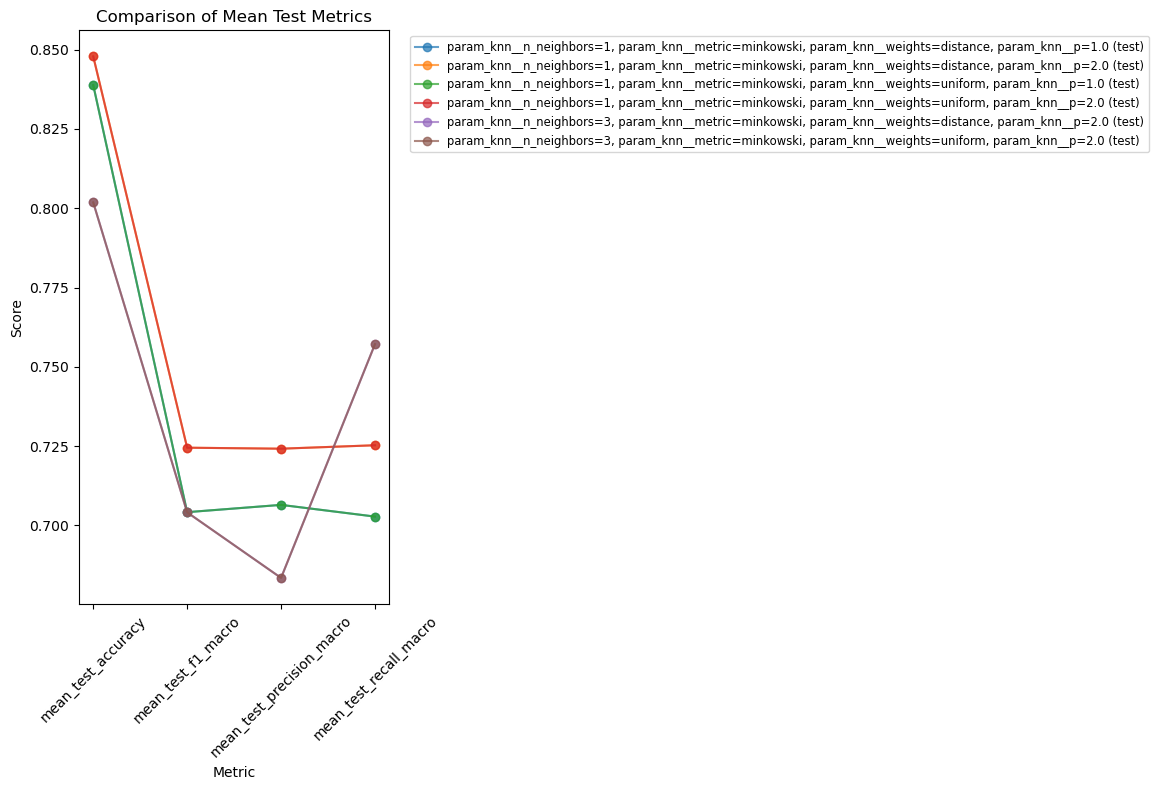

In [67]:
view_test_metrics_pipeline(False, 10, results)

In [111]:
pipeline = Pipeline([
    ('oversampler', SMOTE(sampling_strategy='auto', random_state=42, k_neighbors=5)),
    ('knn', KNeighborsClassifier())
])